In [ ]:
'''
Run below to start clients manunally

source python3_venv/bin/activate
cd fedn/fedland
export RESULTS_DIR=~/fedn/fedland/results
export CLIENT_ID=0
export TEST_ID=37b7ebdf-e691-49fd-8fc3-bef925dee355
fedn client start -n $CLIENT_ID --validator=False --init settings-client-local.yaml
'''

In [1]:
from fedland.utils import load_all_training_results, plot_results_overview_plotly, plot_results_evolution_plotly, plot_results_pct_change_plotly

df = load_all_training_results(ignore_validate = True)

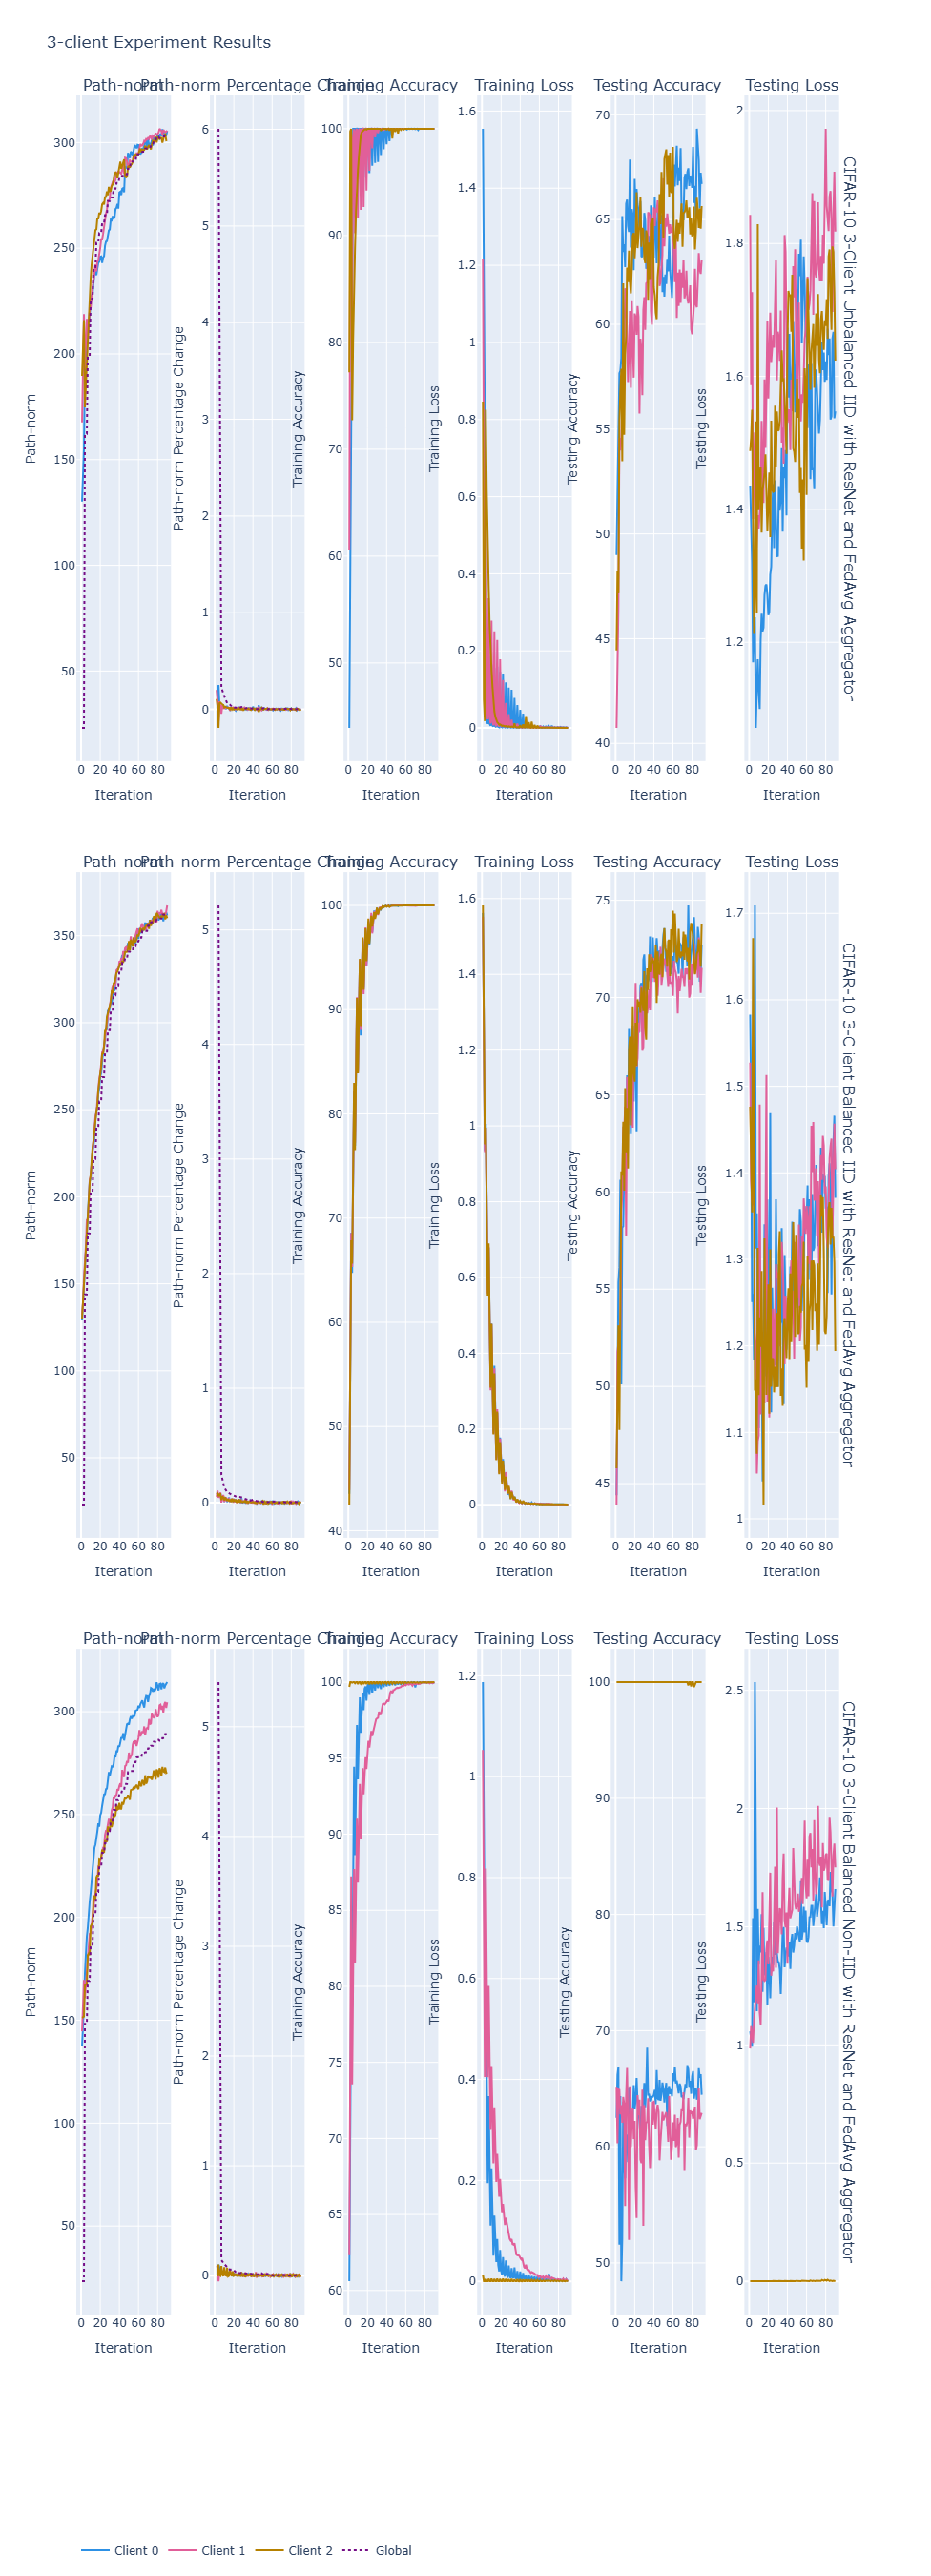

In [2]:
plot_results_overview_plotly(df, 3)

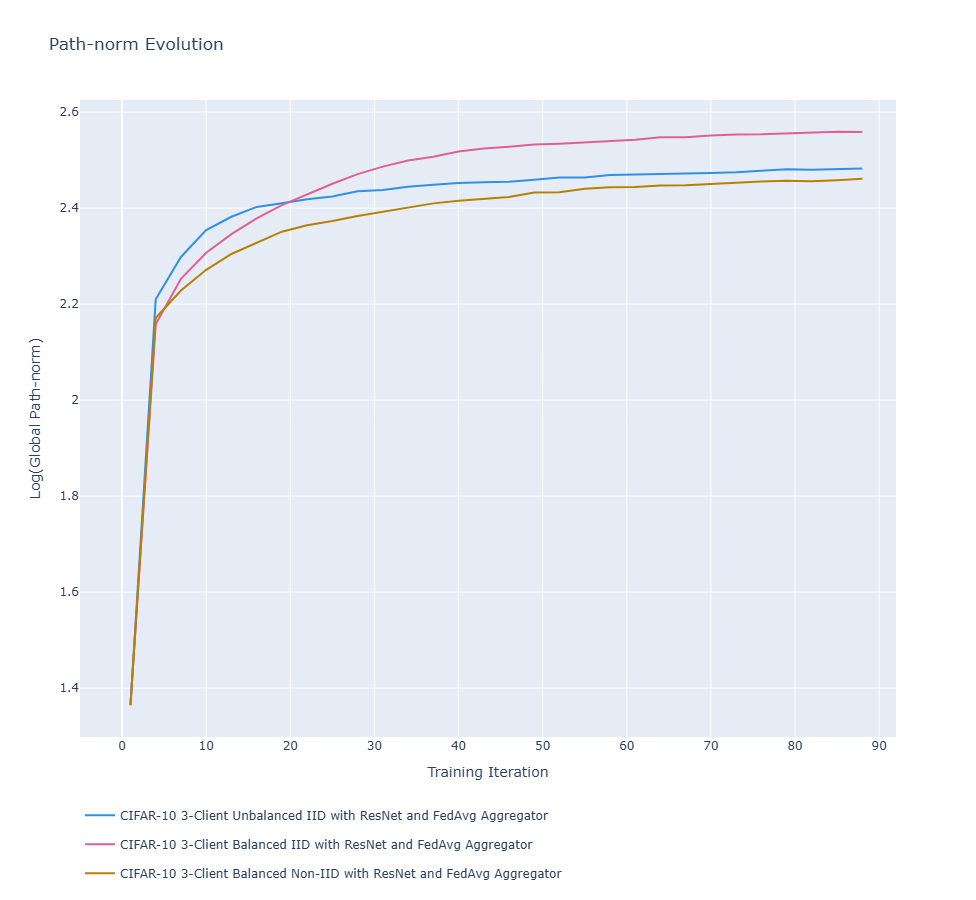

In [3]:
plot_results_evolution_plotly(df)

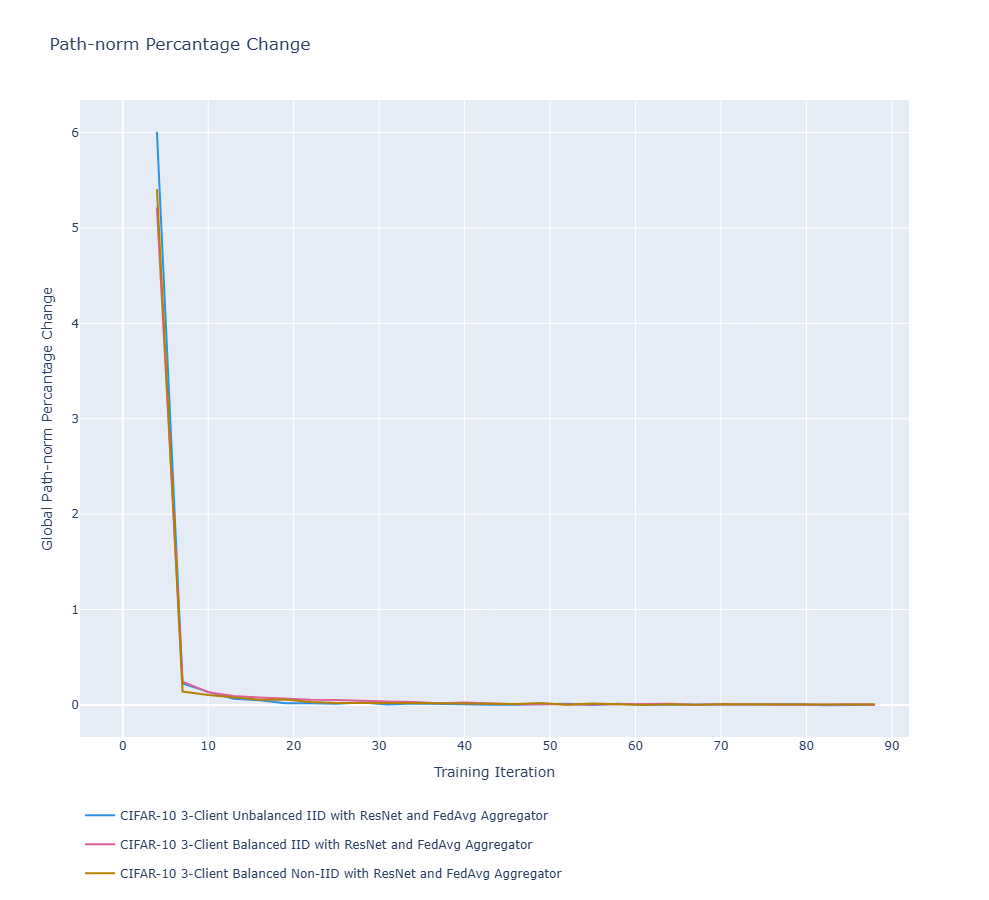

In [4]:
plot_results_pct_change_plotly(df)

In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from fedland.utils import get_experiment_description

# Define some useful colours
colours = px.colors.qualitative.Dark24[:2] + px.colors.qualitative.Dark24[6:8] + px.colors.qualitative.Dark24[14:] + [px.colors.qualitative.Dark24[5]]

experiment_ids = df["experiment_id"].unique()
n_experiments = len(experiment_ids)

df_global_path_norm = df[['experiment_id', 'global_path_norm']].drop_duplicates()
df_global_path_norm['description'] = [get_experiment_description(i) for i in df_global_path_norm['experiment_id']]

fig = go.Figure()
[fig.add_trace(go.Scatter(x = df_global_path_norm[df_global_path_norm['experiment_id'] == experiment_ids[i]].index + 1,
                          y = np.log10(df_global_path_norm[df_global_path_norm['experiment_id'] == experiment_ids[i]]['global_path_norm']),
                          mode = 'lines',
                          legendgroup = df_global_path_norm['description'][df_global_path_norm['experiment_id'] == experiment_ids[i]].unique()[0],
                          line_color = colours[i % len(colours)],
                          name = df_global_path_norm['description'][df_global_path_norm['experiment_id'] == experiment_ids[i]].unique()[0],
                          showlegend = True)) for i in range(n_experiments)]
fig.update_layout(height = 900, width = 1600,
                  legend = dict(orientation = 'h'),
                  title_text = 'Path-norm Evolution',
                  xaxis_title = 'Training Iteration',
                  yaxis_title = 'Log(Global Path-norm)')
fig.update_xaxes(range = [df_global_path_norm.index.min() - 5, df_global_path_norm.index.max() + 5])

fig.show()
fig.write_image('./results/evolution.png', height = 900, width = 4500)

In [ ]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define some useful colours
colours = px.colors.qualitative.Dark24[:2] + px.colors.qualitative.Dark24[6:8] + px.colors.qualitative.Dark24[14:] + [px.colors.qualitative.Dark24[5]]

df_experiments = pd.read_json('./results/experiments.json')
experiment_ids = ['b451d047-c9b3-450c-be7b-42c8a0c6d7b4',
                  '630c180e-e292-4fc3-8f7c-6f6655855a5b',
                  'aee656c0-5dd4-4fba-b1e4-1cdf52cd7ac0']
experiments = []
experiment_descriptions = []

for experiment_id in experiment_ids:
    client_number = 1
    
    df_clients = pd.read_json('./results/' + experiment_id + '/0/training.json')
    df_clients['client'] = 0
    
    while os.path.exists('./results/' + experiment_id + '/' + str(client_number) + '/training.json'):
        df_client_temp = pd.read_json('./results/' + experiment_id + '/' + str(client_number) + '/training.json')
        df_client_temp['client'] = client_number
    
        df_clients = pd.concat([df_clients, df_client_temp])
    
        client_number += 1

    experiments += [df_clients]
    experiment_descriptions += [df_experiments[df_experiments['id'] == experiment_id]['description'].iloc[0]]

fig = make_subplots(rows = len(experiment_ids), cols = 5,
                    row_titles = experiment_descriptions,
                    subplot_titles = ['Path-norm',
                                      'Training Accuracy', 'Training Loss',
                                      'Testing Accuracy', 'Testing Loss'] * len(experiment_ids),
                    horizontal_spacing = 0.05,
                    vertical_spacing = 0.05)

for j in range(len(experiments)):
    # Local Path-norm
    [[fig.add_trace(go.Scatter(x = experiments[j].index[experiments[j]['client'] == i] + 1,
                              y = experiments[j]['path_norm'][experiments[j]['client'] == i],
                              mode = 'lines',
                              legendgroup = 'Client ' + str(i),
                              line_color = colours[i % len(colours)],
                              name = 'Client ' + str(i),
                              showlegend = True if j == 0 else False),
                   row = j + 1, col = 1),
      # Update x- and y-axes properties
      fig.update_xaxes(title_text = 'Iteration', row = j + 1, col = 1),
      fig.update_yaxes(title_text = 'Path-norm', row = j + 1, col = 1)] for i in experiments[j]['client'].unique()]
    # Global Path-norm
    fig.add_trace(go.Scatter(x = experiments[j].index[experiments[j]['client'] == 0] + 1,
                             y = experiments[j]['global_path_norm'][experiments[j]['client'] == 0],
                             mode = 'lines',
                             legendgroup = 'Global Path-norm',
                             line = dict(dash = 'dot'),
                             line_color = colours[client_number % len(colours)],
                             name = 'Global Path-norm',
                             showlegend = True if j == 0 else False),
                  row = j + 1, col = 1)
    # Training Accuracy
    [[fig.add_trace(go.Scatter(x = experiments[j].index[experiments[j]['client'] == i] + 1,
                              y = experiments[j]['train_accuracy'][experiments[j]['client'] == i],
                              mode = 'lines',
                              legendgroup = 'Client ' + str(i),
                              line_color = colours[i % len(colours)],
                              name = 'Client ' + str(i),
                              showlegend = False),
                   row = j + 1, col = 2),
      # Update x- and y-axes properties
      fig.update_xaxes(title_text = 'Iteration', row = j + 1, col = 2),
      fig.update_yaxes(title_text = 'Training Accuracy', row = j + 1, col = 2)] for i in experiments[j]['client'].unique()]
    # Training Loss
    [[fig.add_trace(go.Scatter(x = experiments[j].index[experiments[j]['client'] == i] + 1,
                              y = experiments[j]['train_loss'][experiments[j]['client'] == i],
                              mode = 'lines',
                              legendgroup = 'Client ' + str(i),
                              line_color = colours[i % len(colours)],
                              name = 'Client ' + str(i),
                              showlegend = False),
                   row = j + 1, col = 3),
      # Update x- and y-axes properties
      fig.update_xaxes(title_text = 'Iteration', row = j + 1, col = 3),
      fig.update_yaxes(title_text = 'Training Loss', row = j + 1, col = 3)] for i in experiments[j]['client'].unique()]
    # Testing Accuracy
    [[fig.add_trace(go.Scatter(x = experiments[j].index[experiments[j]['client'] == i] + 1,
                              y = experiments[j]['test_accuracy'][experiments[j]['client'] == i],
                              mode = 'lines',
                              legendgroup = 'Client ' + str(i),
                              line_color = colours[i % len(colours)],
                              name = 'Client ' + str(i),
                              showlegend = False),
                   row = j + 1, col = 4),
      # Update x- and y-axes properties
      fig.update_xaxes(title_text = 'Iteration', row = j + 1, col = 4),
      fig.update_yaxes(title_text = 'Testing Accuracy', row = j + 1, col = 4)] for i in experiments[j]['client'].unique()]
    # Testing Loss
    [[fig.add_trace(go.Scatter(x = experiments[j].index[experiments[j]['client'] == i] + 1,
                              y = experiments[j]['test_loss'][experiments[j]['client'] == i],
                              mode = 'lines',
                              legendgroup = 'Client ' + str(i),
                              line_color = colours[i % len(colours)],
                              name = 'Client ' + str(i),
                              showlegend = False),
                   row = j + 1, col = 5),
      # Update x- and y-axes properties
      fig.update_xaxes(title_text = 'Iteration', row = j + 1, col = 5),
      fig.update_yaxes(title_text = 'Testing Loss', row = j + 1, col = 5)] for i in experiments[j]['client'].unique()]

fig.update_layout(height = 900 * len(experiments),
                  width = 4500,
                  legend = dict(orientation = 'h',
                                xanchor = 'left',
                                x = 0.0325,
                                yanchor = 'bottom',
                                y = 1.0075),
                  title_text = str(client_number) + '-client Experiment Results')
fig.update_xaxes(range = [df_clients.index.min() - 5, df_clients.index.max() + 5])

fig.show()
fig.write_image('./results/' + experiment_id + '/overivew.png', height = 900 * len(experiments), width = 4500)